<a href="https://colab.research.google.com/github/HikaruHotta/roadUNet/blob/master/UNetBaseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# use this code to keep cloba alive basically clicks so colab doesn't turn off 
# (usually turns off fter 90 minutes of idle)
#function ClickConnect(){
#    console.log("Working");
# document.querySelector("colab-toolbar-button#connect").click()
#}setInterval(ClickConnect,60000)

# Python Modules
import numpy as np
import os
import cv2
import math
import matplotlib.pyplot as plt
import time
import datetime

from tqdm import trange
from tqdm.notebook import tqdm

from time import sleep

import glob

from PIL import Image

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data

In [0]:
# constants and paths to our data

IMG_WIDTH, IMG_HEIGHT = 256, 256
NUM_CHANNELS = 3
NEW_IMAGE_SHAPE = (256, 256, 3)
NEW_MASK_SHAPE = (256, 256)

train_path = '/content/drive/Shared drives/CS231n Project/mass_roads_cropped/train'
valid_path = '/content/drive/Shared drives/CS231n Project/mass_roads_cropped/valid'
test_path = '/content/drive/Shared drives/CS231n Project/mass_roads_cropped/test'
checkpoint_path = '/content/drive/Shared drives/CS231n Project/checkpoints'
model_save_path = '/content/drive/Shared drives/CS231n Project/UNet_0508202.pt'

avg_image = np.load('/content/drive/Shared drives/CS231n Project/avg_image.npy')
channel_wise_mean = np.mean(avg_image, axis=(0,1)) / 255

In [5]:
# set up tensorboard

# Install latest Tensorflow build
import tensorflow as tf
from tensorflow import summary
%load_ext tensorboard

current_time = str(datetime.datetime.now().timestamp())
train_log_dir = 'logs/tensorboard/train/' + current_time
test_log_dir = 'logs/tensorboard/test/' + current_time
train_summary_writer = summary.create_file_writer(train_log_dir)
test_summary_writer = summary.create_file_writer(test_log_dir)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
## https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py

from datetime import datetime

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            print("saving checkpoint")
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        now = datetime.now()
        date_time = now.strftime("%H_%M_%S")
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model, checkpoint_path + '/' + date_time + '_checkpoint.pt')
        self.val_loss_min = val_loss

In [0]:
# define custom dataset class which is interpretable by DataLoader

class CustomDataset():
    def __init__(self, image_paths, target_paths):
        self.image_paths = image_paths
        self.target_paths = target_paths
        self.image_transforms = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize(channel_wise_mean, [1, 1, 1])
                             ])
        self.mask_transforms = transforms.ToTensor()

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])
        mask = Image.open(self.target_paths[index]).convert('L')
        t_image = self.image_transforms(image)
        t_mask = self.mask_transforms(mask)
        t_mask = t_mask.squeeze()
        return t_image, t_mask

    def __len__(self):  # return count of sample we have
        return len(self.image_paths)

In [8]:
# get all the image and mask path and number of images
def generate_loader(path, batch_size):
  folder_sat = glob.glob(path + "/sat/*.tif")
  folder_map = glob.glob(path + "/map/*.tif")
  len_data = len(folder_sat)
  print(len_data)
  sat_paths = folder_sat
  map_paths = folder_map
  dataset = CustomDataset(sat_paths, map_paths)
  loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
  return loader

BATCH_SIZE = 32

#valid_loader = generate_loader(valid_path, BATCH_SIZE)
test_loader = generate_loader(test_path, BATCH_SIZE)
#train_loader = generate_loader(train_path, BATCH_SIZE)

1225


In [0]:
# https://github.com/jvanvugt/pytorch-unet/blob/master/unet.py

class UNet(nn.Module):
    def __init__(
        self,
        in_channels=3,
        n_classes=1,
        depth=5,
        wf=6,
        padding=False,
        batch_norm=False,
        up_mode='upconv',
    ):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (wf + i), padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(
                UNetUpBlock(prev_channels, 2 ** (wf + i), up_mode, padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

In [0]:
def train():
    # training 
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = UNet(in_channels=3, n_classes=2, padding=True).to(device)
    optim = torch.optim.Adam(model.parameters())

    dataloader = train_loader
    val_dataloader = valid_loader
    
    epochs = 1000
    patience = 5

    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in tqdm(range(epochs)):
        tic = time.perf_counter()

        train_losses = []
        N = 0
        model.train()
        for X, y in tqdm(dataloader):
            X = X.to(device)  # [N, 3, H, W]
            y = y.to(device)  # [N, H, W] with class indices (0, 1)
            n = X.shape[0]
            N += n # increment counter of training examples
            prediction = model(X) # [N, 1, H, W]
            loss = F.cross_entropy(prediction, y.long()) * n # multiply by batchsize since cross_entropy takes the average
            train_losses.append(loss)
            optim.zero_grad()
            loss.backward()
            optim.step()

        avg_training_loss = np.sum(np.array(train_losses)) / N 

        ## compute validation error
        val_losses = []
        N = 0
        model.eval()
        with torch.no_grad():
            for X, y in tqdm(val_dataloader):
                X = X.to(device)  # [N, 3, H, W]
                y = y.to(device)  # [N, H, W] with class indices (0, 1)
                n = X.shape[0]
                N += n
                prediction = model(X) # [N, 1, H, W]
                loss = F.cross_entropy(prediction, y.long()) * n
                val_losses.append(loss)
        
        avg_val_loss = np.sum(np.array(val_losses)) / N

        toc = time.perf_counter()
        print(f"Epoch {epoch}: Train Loss = {avg_training_loss}, Validation Loss = {avg_val_loss}, and took {toc - tic:0.4f} seconds")

        with train_summary_writer.as_default():
          tf.summary.scalar('training loss', avg_training_loss.item(), step=epoch)
          tf.summary.scalar('validation loss', avg_val_loss.item(), step=epoch)

        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            break
        
    # save model
    torch.save(model, model_save_path)

In [0]:
%tensorboard --logdir logs/tensorboard

In [0]:
train()

In [0]:
# At test time, restart the runtime because cuda runs out of memory
model = torch.load(checkpoint_path + '/10_44_17_checkpoint.pt')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly cl


Test Loss = 0.10024508088827133, Rand Error = 0.046776536192337424, Pixel Error = 9.436707812465828, and took 0.2293 seconds


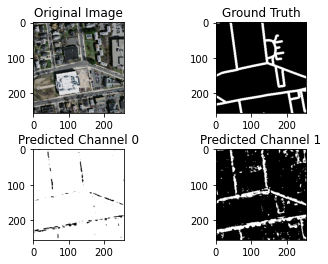

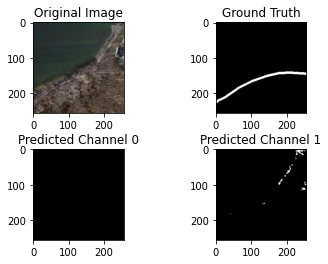

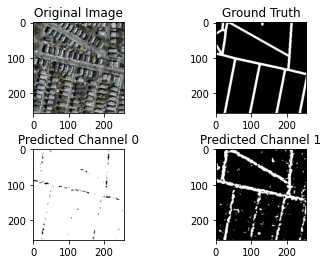

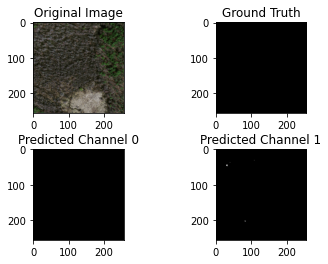

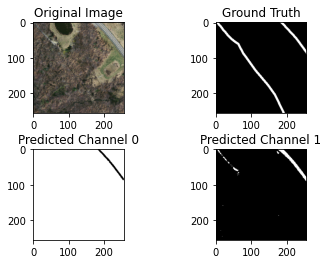

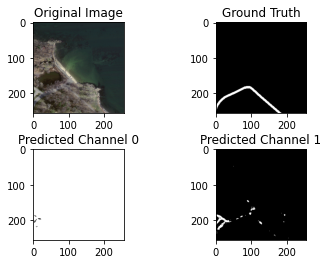

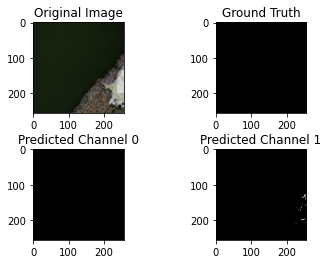

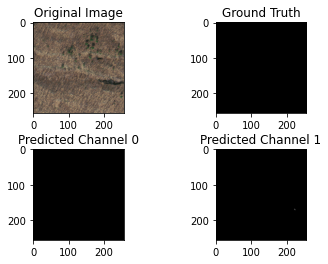

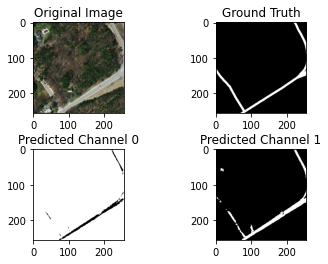

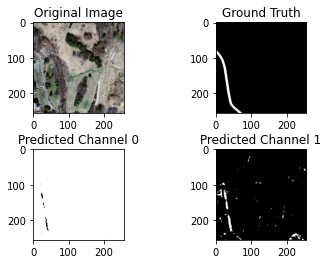

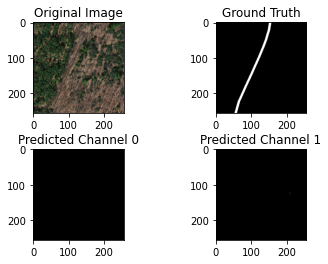

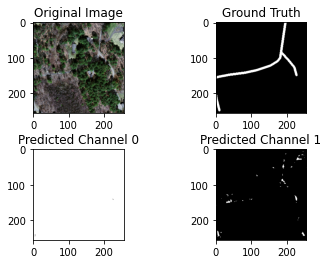

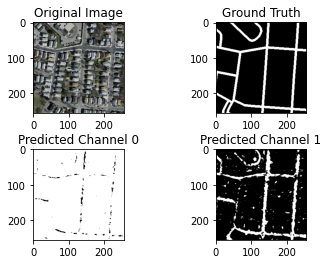

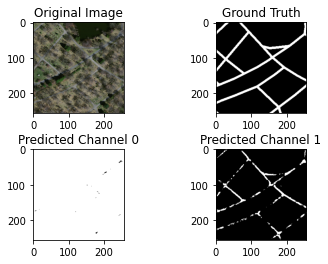

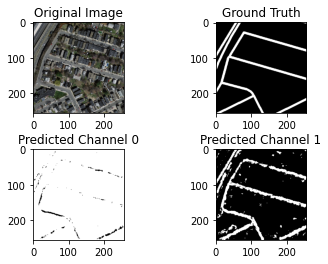

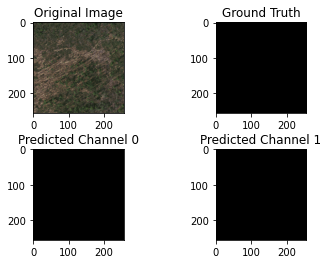

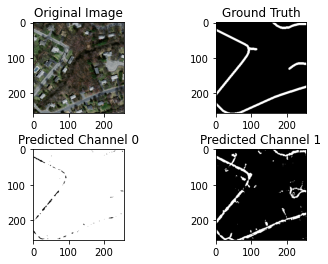

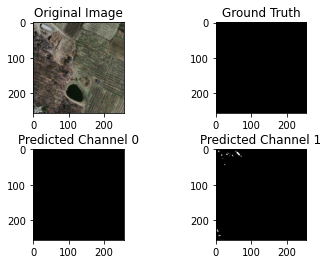

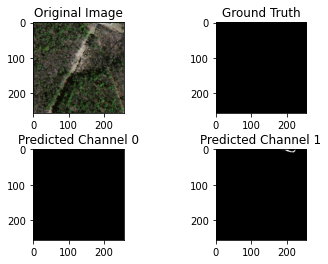

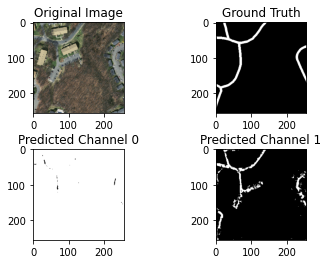

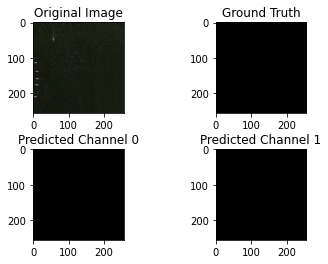

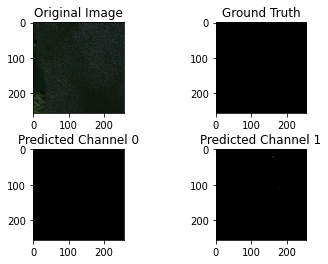

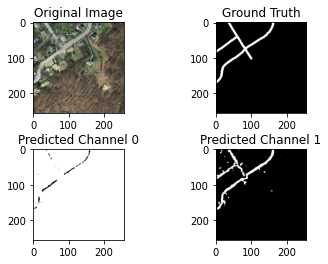

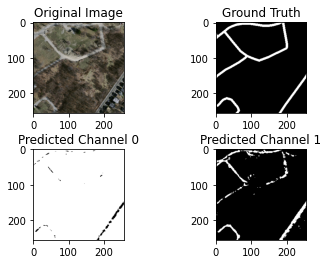

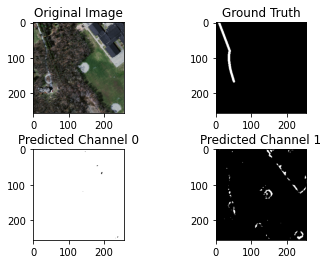

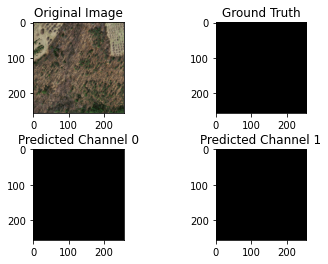

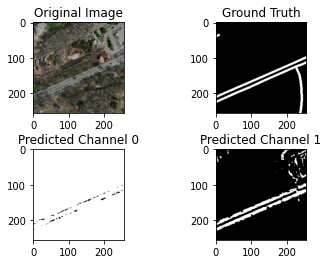

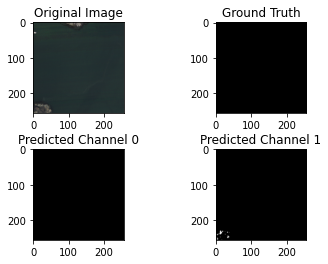

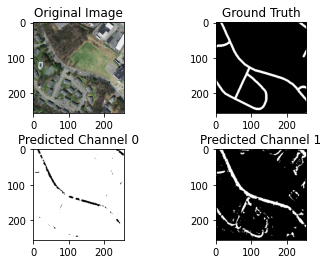

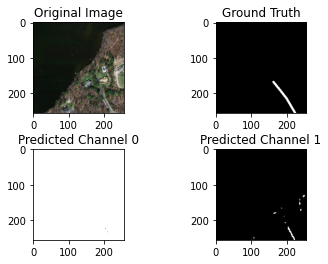

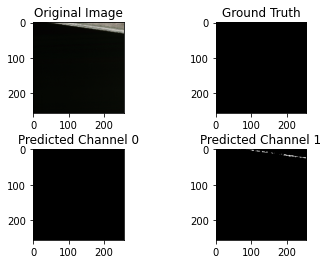

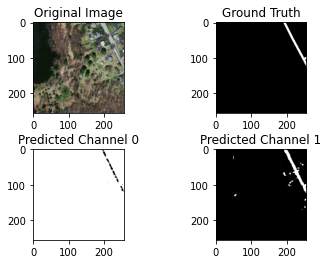

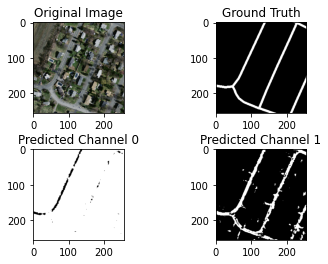

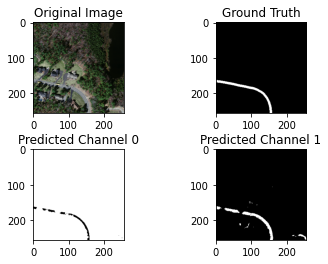

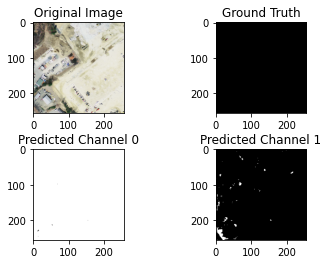

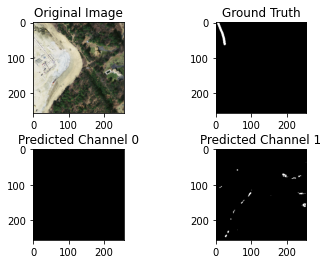

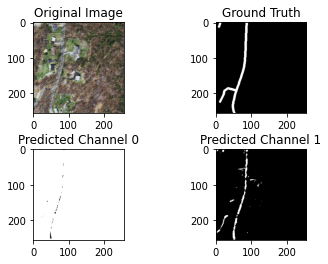

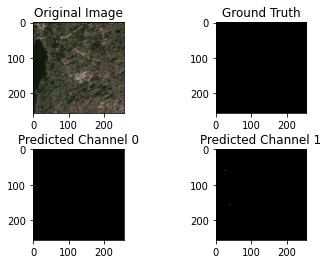

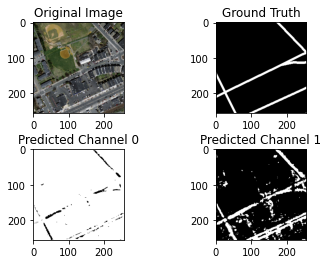

In [46]:
# test model

# https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_metrics.html#sphx-glr-auto-examples-segmentation-plot-metrics-py
from skimage.metrics import (adapted_rand_error,
                              variation_of_information)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_losses = []
rand_error = []
pixel_error = []
N = 0
THRESHOLD = -0.5
counter = 0

model.eval()
with torch.no_grad():
    for X, y in tqdm(test_loader):
        tic = time.perf_counter()

        X = X.to(device)  # [N, 3, H, W]
        y = y.to(device)  # [N, H, W] with class indices (0, 1)
        n = X.shape[0]
        N += n
        prediction = model(X) # [N, 1, H, W]

        # compute loss
        loss = F.cross_entropy(prediction, y.long()) * n
        test_losses.append(loss)

        # Generate Masks
        predicted_mask_0 = prediction[5].permute(1,2,0)[:,:,0].cpu().numpy()
        predicted_mask_0[predicted_mask_0>THRESHOLD] = 1
        predicted_mask_0[predicted_mask_0<=THRESHOLD] = 0

        predicted_mask_1 = prediction[5].permute(1,2,0)[:,:,1].cpu().numpy()
        predicted_mask_1[predicted_mask_1>THRESHOLD] = 1
        predicted_mask_1[predicted_mask_1<=THRESHOLD] = 0

        # Plot Predictions
        fig = plt.figure(counter)
        fig.subplots_adjust(hspace=0.4)
        ax1 = fig.add_subplot(2,2,1)
        ax1.set_title('Original Image')
        ax1.imshow(X[5].permute(1,2,0).cpu().numpy() + channel_wise_mean)
        ax2 = fig.add_subplot(2,2,2)
        ax2.set_title('Ground Truth')
        ax2.imshow(y[5].cpu().numpy(), cmap='gray')
        ax3 = fig.add_subplot(2,2,3)
        ax3.set_title('Predicted Channel 0')
        ax3.imshow(predicted_mask_0, cmap='gray')  
        ax4 = fig.add_subplot(2,2,4)
        ax4.set_title('Predicted Channel 1')
        ax4.imshow(predicted_mask_1, cmap='gray')  
        counter += 1

        # compute random error
        prediction = prediction.permute(0,2,3,1)[:,:,:,1].cpu().numpy()
        prediction[prediction>THRESHOLD] = 1
        prediction[prediction<=THRESHOLD] = 0
        prediction = prediction.astype(int) + 1
        y = y.cpu().numpy().astype(int) + 1
        r_error = 0
        for i in range(n):
            error, precision, recall = adapted_rand_error(y[i], prediction[i])
            r_error += error
        rand_error.append(r_error)

        # compute pixel-wise error
        prediction -= 1
        y -= 1
        p_error = np.sqrt(np.sum((y - prediction)**2))
        pixel_error.append(p_error)
   
    avg_test_loss = np.sum(np.array(test_losses)) / N
    avg_rand_error = np.sum(np.array(rand_error)) / N
    avg_pixel_error = np.sum(np.array(pixel_error)) / N


    toc = time.perf_counter()
    print(f"Test Loss = {avg_test_loss}, Rand Error = {avg_rand_error}, Pixel Error = {avg_pixel_error}, and took {toc - tic:0.4f} seconds")


Calculate **Warping Error** from https://github.com/ait-ngcms/warpdet/blob/master/warpingDetection.py

*Warping error between two segmentations is the minimum mean square error between the pixels of the target segmentation. Read here: https://ashm8206.github.io/2018/04/08/Segmentation-Metrics.html*

Questions to ask team:

1. Do we copy and paste all the code or is there a more efficient way of doing this?

In [0]:
#set-up
import os
import sys
import string
import timeit
import time

import numpy as np
import matplotlib.cm as cm
import matplotlib.image as mpimg

from PIL import Image
from pylab import plot
from pylab import title
from pylab import show
from pylab import ylabel
from pylab import xlabel
from pylab import text
from pylab import figure
from pylab import subplot
from pylab import imshow
from pylab import subplots

# mser
import numpy as np
import cv2

# canny
from matplotlib import pyplot as plt
from numpy import array
import math

**Rand error**: The Rand index is defined as a measure
of agreement. (This paper defines it as measure of disagreement)(https://virenjain.org/pdf/JainEtal_CVPR10.pdf)

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html
Actual implementation from Scikit-Learn

Each object in a segmentation consists of a set of pixels sharing a common label. The Rand error is the frequency with which the two segmentations disagree over whether a pair of pixels belongs to same
or different objects.

In [0]:
from sklearn.metrics.cluster import adjusted_rand_score

In [0]:
store_rand_scores = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n = 0
# model.train()
# model.eval()
#models have diff test time and training time. model.train and model.eval sets the flag for which mode it's in.
#does it optimize? unsure
with torch.no_grad():
  for X, y in tqdm(test_loader): #Assuming X is predicted, y is ground truth..
    X = X.to(device)
    y = y.to(device)
    prediction = model(X) # Shape: n c h w , want it to be n h w c
    prediction = prediction.permute(0,2,3,1).cpu().numpy() #cpu... converts it to a numpy array
    y = y.cpu().numpy() #copying what's not on gpu back on gpu (?)
    #add another dimension to y
    y = y[:,np.newaxis]
    #Debug : Print y?
    rand_score = adjusted_rand_score(prediction[:,:,:,1],y) #want the first channel
    store_rand_scores.append(rand_score)
    n += X.shape[0]
#probably take the mean of all the scores?
mean_rand_score = np.sum(store_rand_scores,axis=0)/n

ValueError: ignored

**Pixel Error**: Just the L2 norm squared // "Naive metric is the pixel error, the number of image pixels on which machine and human boundary labelings disagree. This metric unduly penalizes minor disagreements over boundary location." (https://virenjain.org/pdf/JainEtal_CVPR10.pdf)

In [0]:
for prediction, y in tqdm(dataloader):
  #format X,y to perform linalg.norm
  dist = numpy.linalg.norm(prediction-y)